In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np


def loadmat(filepath):
    return sio.loadmat(filepath, simplify_cells=True)

mat = loadmat('B0005.mat')
print(mat.keys())
print(mat['B0005'].keys())
print(len(mat['B0005']['cycle']))
print(mat['B0005']['cycle'][1].keys())
print(mat['B0005']['cycle'][1]['data'].keys())
print(mat['B0005']['cycle'][1]['type'])
print(mat['B0005']['cycle'][1]['ambient_temperature'])
print(mat['B0005']['cycle'][0]['time'])


dict_keys(['__header__', '__version__', '__globals__', 'B0005'])
dict_keys(['cycle'])
616
dict_keys(['type', 'ambient_temperature', 'time', 'data'])
dict_keys(['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'Capacity'])
discharge
24
[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8.0000e+00 1.7921e+01]


In [2]:
df = pd.DataFrame(data=mat['B0005']['cycle'][5]['data'])
df.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,Capacity
0,4.188187,-0.001754,24.734266,-0.0006,0.000,0.000,1.835349
1,4.187198,-0.001792,24.740500,-0.0006,4.203,16.797,1.835349
2,3.979995,-2.015479,24.791450,-1.9982,3.055,35.766,1.835349
3,3.958170,-2.014815,24.942960,-1.9982,3.023,53.891,1.835349
4,3.941673,-2.011893,25.116400,-1.9982,3.000,72.094,1.835349


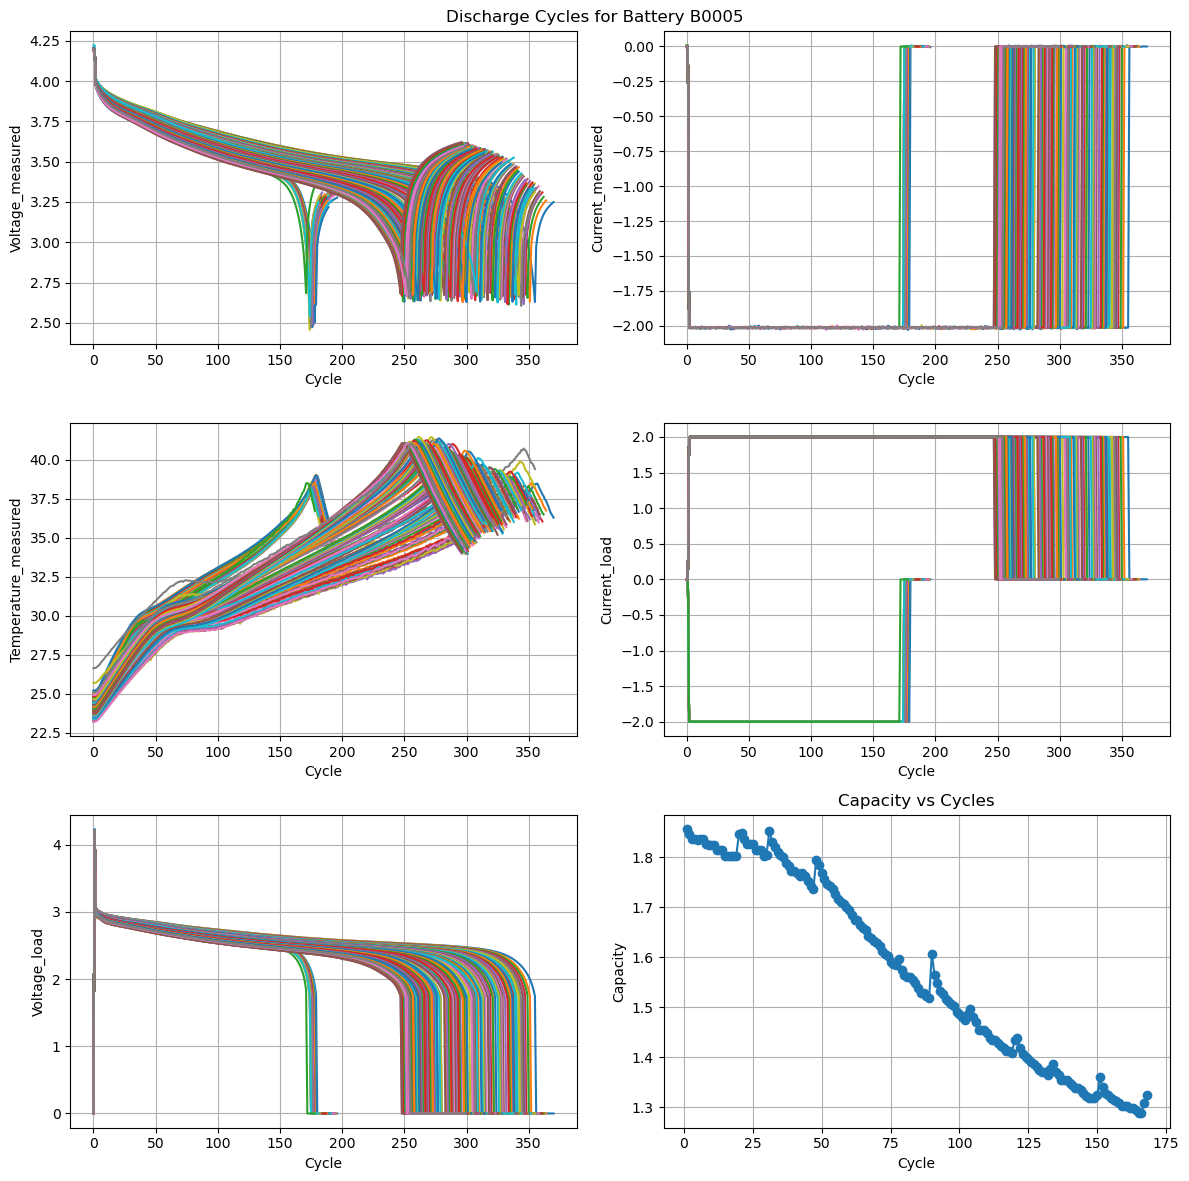

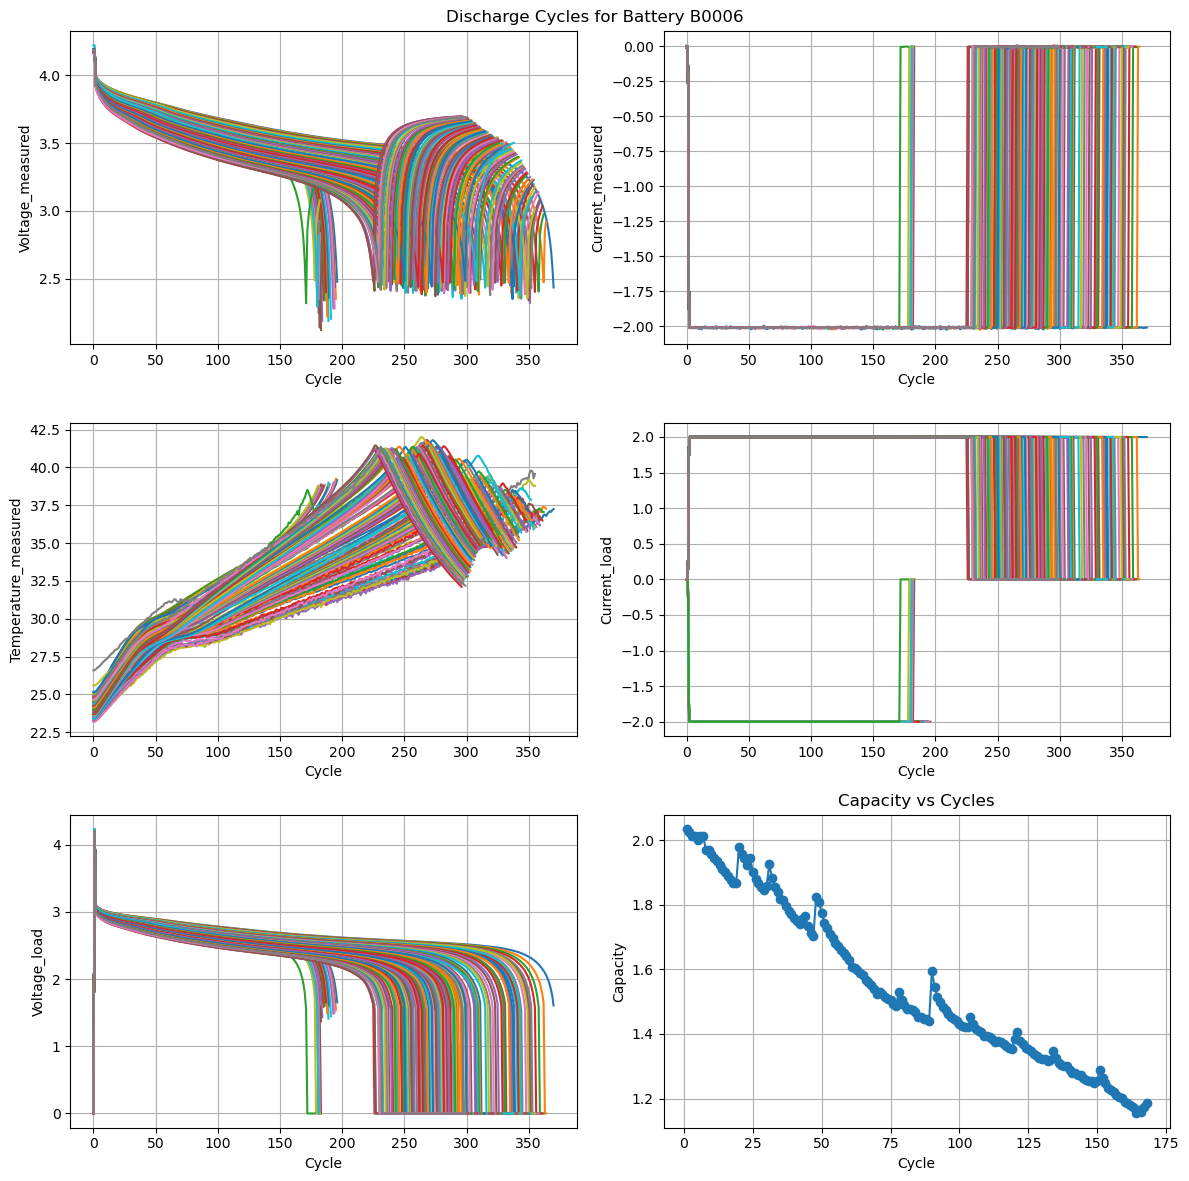

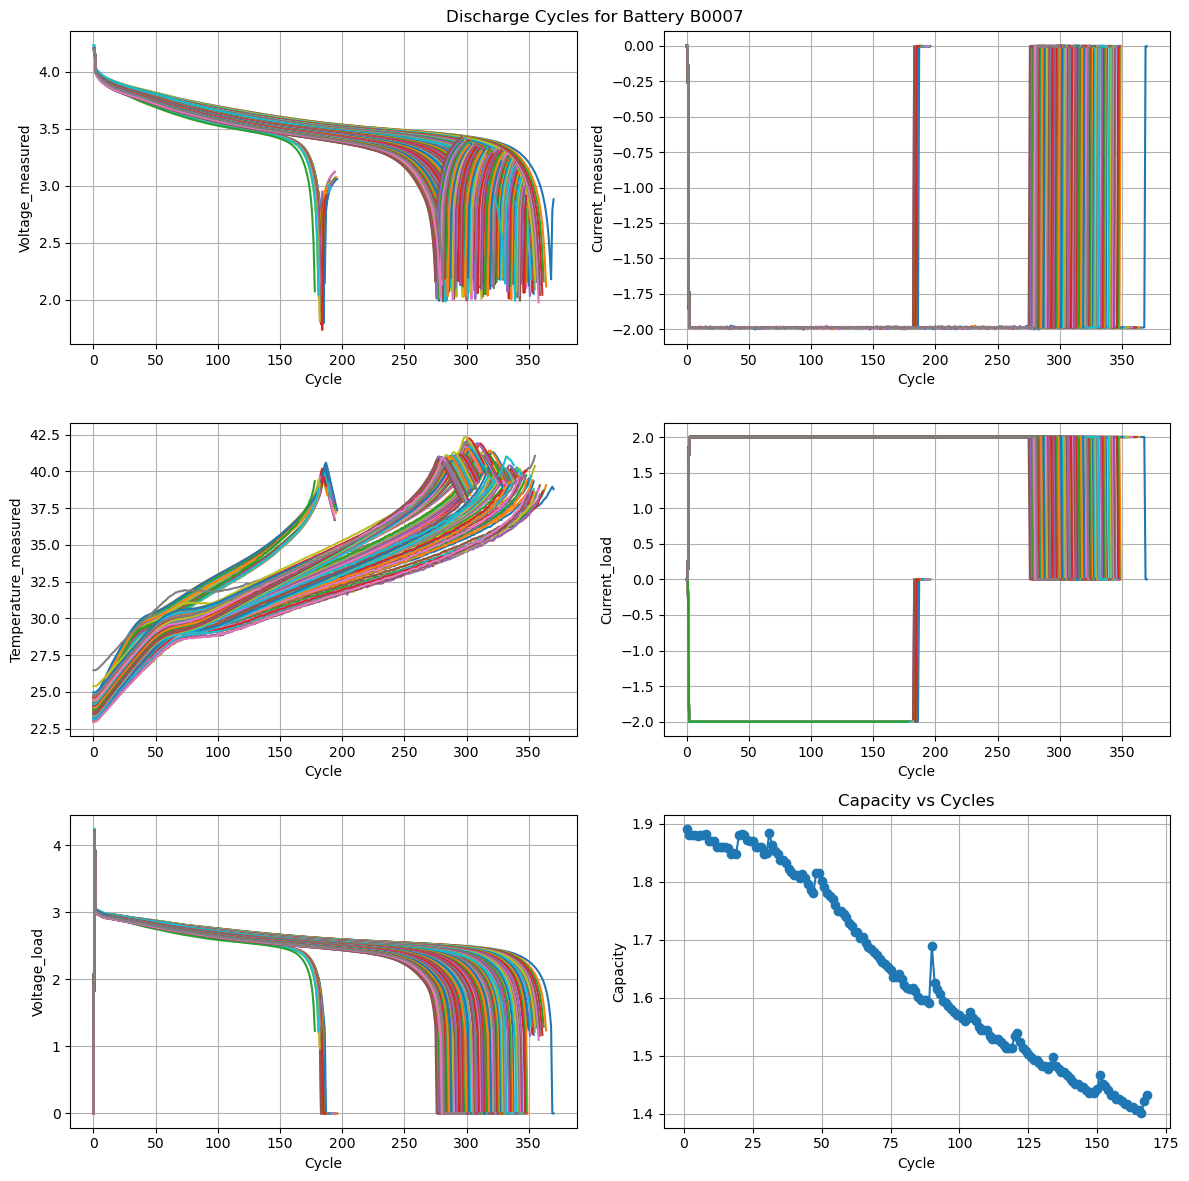

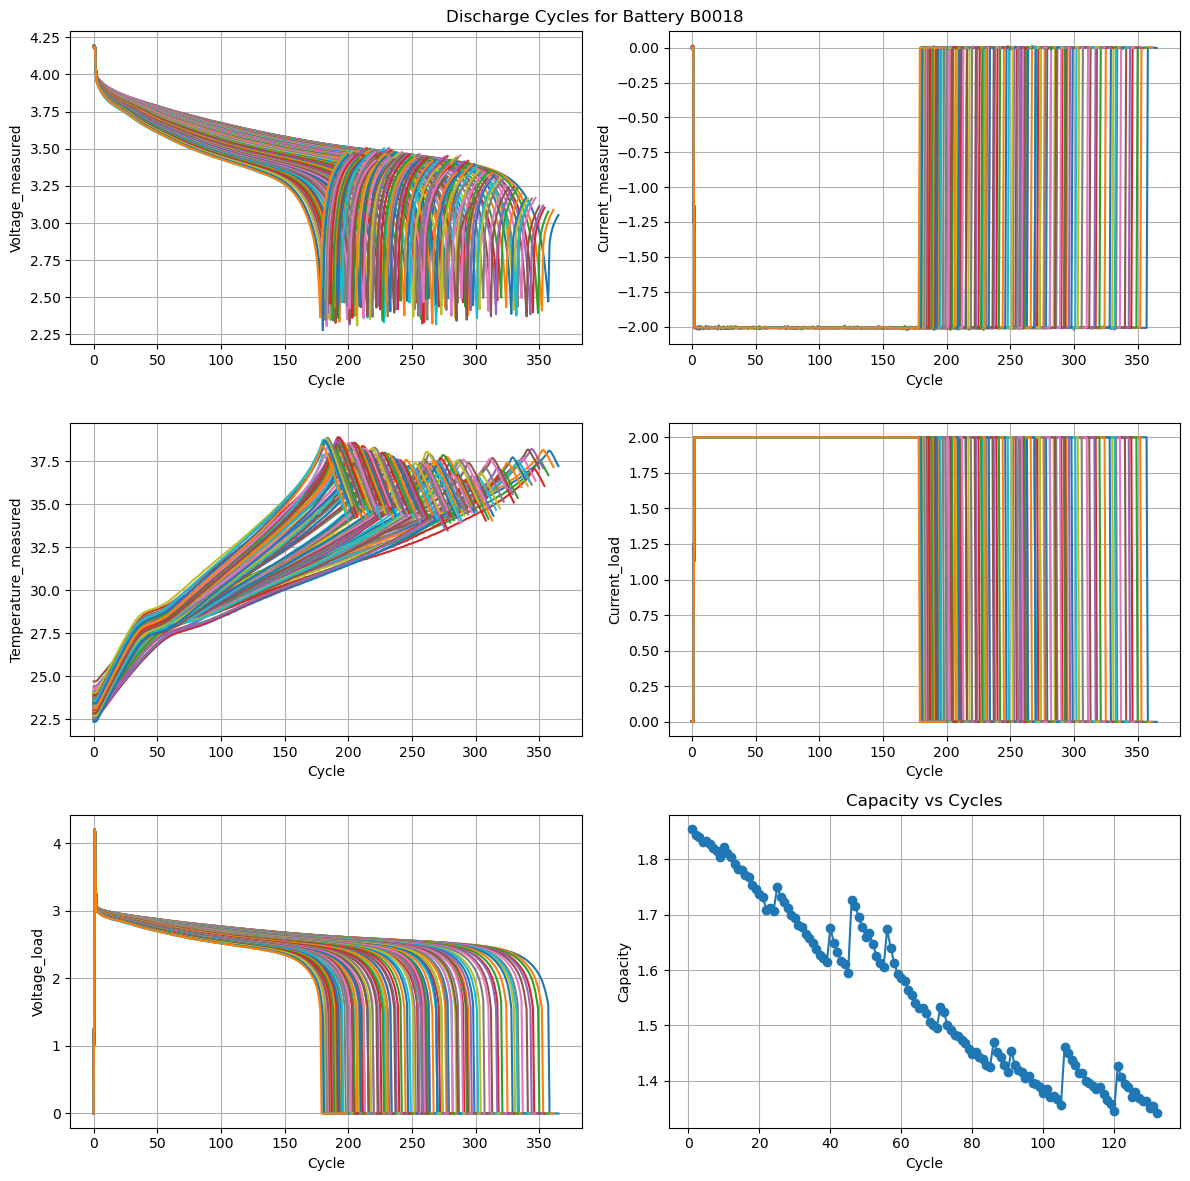

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

mat_b0005 = loadmat('B0005.mat')
mat_b0006 = loadmat('B0006.mat')
mat_b0007 = loadmat('B0007.mat')
mat_b0018 = loadmat('B0018.mat')

def plot_discharge_cycles(mat, battery_name):
    total_cycles = len(mat[battery_name]['cycle'])
    columns_to_plot = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load']
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    fig.suptitle(f'Discharge Cycles for Battery {battery_name}')

    capacity_data = []
    for cycle_data in mat[battery_name]['cycle']:
        if cycle_data['type'] == 'discharge':
            data = cycle_data['data']
            if isinstance(data['Capacity'], list):
                capacity_data.append(data['Capacity'][-1])
            else:
                capacity_data.append(data['Capacity'])
    axs[2, 1].plot(range(1, len(capacity_data) + 1), capacity_data, marker='o', linestyle='-')
    axs[2, 1].set_xlabel('Cycle')
    axs[2, 1].set_ylabel('Capacity')
    axs[2, 1].set_title('Capacity vs Cycles')
    axs[2, 1].grid(True)

    # Iterate over each column
    for idx, col in enumerate(columns_to_plot):
        if col not in ['Time', 'Capacity']:
            # Initialize lists to store data from all cycles for the current column
            all_data = []

            # Iterate through each cycle
            for cycle_data in mat[battery_name]['cycle']:
                if cycle_data['type'] == 'discharge':
                    data = cycle_data['data']
                    all_data.append(data[col])

            # Plot the data for the current column
            row_idx = idx // 2
            col_idx = idx % 2
            for data in all_data:
                axs[row_idx, col_idx].plot(data, label=col)
            axs[row_idx, col_idx].set_xlabel('Cycle')
            axs[row_idx, col_idx].set_ylabel(col)
            axs[row_idx, col_idx].grid(True)

    plt.tight_layout()
    plt.show()

plot_discharge_cycles(mat_b0005, 'B0005')
plot_discharge_cycles(mat_b0006, 'B0006')
plot_discharge_cycles(mat_b0007, 'B0007')
plot_discharge_cycles(mat_b0018, 'B0018')


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

def get_temp_critical(temp_measured, timestamps):
    highest_temp = max(temp_measured)
    max_temp_index = np.argmax(temp_measured)
    return timestamps[max_temp_index]

# Function to calculate the time at which the lowest voltage has been measured
def get_voltage_critical(voltage_measured, timestamps):
    lowest_voltage = min(voltage_measured)
    min_voltage_index = np.argmin(voltage_measured)
    return timestamps[min_voltage_index]

# Function to calculate the first instance at which voltage drops below 1 volt after 1500 seconds
def get_voltage_load_critical(voltage_load_measured, timestamps):
    for i, voltage_load in enumerate(voltage_load_measured):
        if timestamps[i] > 1500 and voltage_load < 1:
            return timestamps[i]
    return -1

# Function to calculate the maximum temperature
def get_max_temp(temp_measured, timestamps):
    max_temp_index = np.argmax(temp_measured)
    return timestamps[max_temp_index]

    
# Function to create dataset
def create_dataset(mat, keys):
    dataset = []
    for key in keys:
        if 'cycle' in mat[key]:
            for cycle_data in mat[key]['cycle']:
                if cycle_data['type'] == 'discharge':
                    data = cycle_data['data']
                    capacity = data['Capacity'][-1] if isinstance(data['Capacity'], list) else data['Capacity']
                    temp_critical = get_temp_critical(data['Temperature_measured'], data['Time'])
                    voltage_critical = get_voltage_critical(data['Voltage_measured'], data['Time'])
                    voltage_load_critical = get_voltage_load_critical(data['Voltage_load'], data['Time'])
                    max_temp = get_max_temp(data['Temperature_measured'], data['Time'])
                    dataset.append([capacity, temp_critical, voltage_critical, voltage_load_critical, max_temp])
    return pd.DataFrame(dataset, columns=['Capacity', 'Temp_Critical', 'Voltage_Critical', 'Voltage_Load_Critical', 'Max_Temp'])



keys_b0005 = ['B0005']
keys_b0006 = ['B0006']
keys_b0007 = ['B0007']
keys_b0018 = ['B0018']

dataset_b0005 = create_dataset(mat_b0005, keys_b0005)
dataset_b0006 = create_dataset(mat_b0006, keys_b0006)
dataset_b0007 = create_dataset(mat_b0007, keys_b0007)
dataset_b0018 = create_dataset(mat_b0018, keys_b0018)

# Train and evaluate regression algorithms for each battery
for dataset, battery_name in zip([dataset_b0005, dataset_b0006, dataset_b0007, dataset_b0018], ['B0005', 'B0006', 'B0007', 'B0018']):
    # Split the dataset into features (X) and target variable (y)
    X = dataset.drop('Capacity', axis=1)
    y = dataset['Capacity']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define a list of popular regression algorithms
    algos = [
        LinearRegression(), HuberRegressor(), KNeighborsRegressor(),
         NuSVR(), SVR(), DecisionTreeRegressor(), ExtraTreeRegressor(),
        RandomForestRegressor(), ExtraTreesRegressor(), XGBRegressor()
    ]

    # Dictionary to store results
    results = {'Algorithm': [], 'Accuracy': [], 'RMSE': []}

    # Train each algorithm and evaluate its performance
    for algo in algos:
        # Train the model
        model = algo
        model.fit(X_train, y_train)

        # Predict capacity
        y_pred = model.predict(X_test)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Calculate accuracy (for regression, we typically use R-squared as a measure of accuracy)
        accuracy = model.score(X_test, y_test)

        # Store results
        results['Algorithm'].append(type(model).__name__)
        results['Accuracy'].append(accuracy)
        results['RMSE'].append(rmse)

    # Create a DataFrame from the results dictionary
    results_df = pd.DataFrame(results)

    # Display the results
    print(f"Results for {battery_name}:")
    print(results_df)


Results for B0005:
               Algorithm  Accuracy      RMSE
0       LinearRegression  0.999999  0.000171
1         HuberRegressor  0.999999  0.000216
2    KNeighborsRegressor  0.999410  0.004661
3                  NuSVR  0.999742  0.003083
4                    SVR  0.909228  0.057838
5  DecisionTreeRegressor  0.999055  0.005902
6     ExtraTreeRegressor  0.998701  0.006919
7  RandomForestRegressor  0.999444  0.004526
8    ExtraTreesRegressor  0.999716  0.003237
9           XGBRegressor  0.998344  0.007811
Results for B0006:
               Algorithm  Accuracy      RMSE
0       LinearRegression  0.999773  0.003841
1         HuberRegressor  0.999624  0.004938
2    KNeighborsRegressor  0.998889  0.008492
3                  NuSVR  0.999560  0.005341
4                    SVR  0.973507  0.041459
5  DecisionTreeRegressor  0.999175  0.007315
6     ExtraTreeRegressor  0.998388  0.010227
7  RandomForestRegressor  0.999314  0.006673
8    ExtraTreesRegressor  0.999377  0.006359
9           XGBRe